In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns

In [2]:
def convert_feature_one_hot_encoder(df: pd.DataFrame, feature: str) -> pd.DataFrame:
    """
    This method receives a Pandas dataframe and convert some features using the One Hot Encoder
    
    :param df: A Pandas dataframe
    :param feature: The name of the feature to convert
    :return: A Pandas dataframe with the features converted
    """
    ohe = OneHotEncoder()
    ohe.fit(df[feature].to_numpy().reshape(-1, 1))
    transformed = ohe.transform(df[feature].to_numpy().reshape(-1, 1)).toarray()
    columns = []
    for c in ohe.get_feature_names_out():
        columns.append(c.replace("x0", feature))
    ohe_df = pd.DataFrame(transformed, columns=columns)
    # Concats the result with the original data
    return pd.concat([df, ohe_df], axis=1)

In [3]:
df = pd.read_csv("dados/bank_t2.txt", delimiter = "\t")

In [4]:
df.head()

,age,marital,education,housing.loan,personal.loan,contact,day.of.week,duration.contact,number.contatcs.campaign,poutcome,term.deposit
0,30,married,basic,1,0,cellular,fri,487,2,nonexistent,0
1,39,single,high.school,0,0,telephone,fri,346,4,nonexistent,0
2,25,married,high.school,1,0,telephone,wed,227,1,nonexistent,0
3,47,married,university.degree,1,0,cellular,mon,58,1,nonexistent,0
4,32,single,university.degree,0,0,cellular,thu,128,3,failure,0


In [5]:
df.describe()

,age,housing.loan,personal.loan,duration.contact,number.contatcs.campaign,term.deposit
count,3836.000000,3836.000000,3836.000000,3836.000000,3836.000000,3836.000000
mean,40.001564,0.543796,0.167101,256.438478,2.535975,0.108186
std,10.236627,0.498143,0.373115,256.860414,2.583371,0.310655
min,19.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,32.000000,0.000000,0.000000,103.000000,1.000000,0.000000
50%,38.000000,1.000000,0.000000,180.000000,2.000000,0.000000
75%,47.000000,1.000000,0.000000,316.000000,3.000000,0.000000
max,88.000000,1.000000,1.000000,3643.000000,35.000000,1.000000


In [6]:
df.groupby("term.deposit").count()

,age,marital,education,housing.loan,personal.loan,contact,day.of.week,duration.contact,number.contatcs.campaign,poutcome
term.deposit,,,,,,,,,,
0,3421,3421,3421,3421,3421,3421,3421,3421,3421,3421
1,415,415,415,415,415,415,415,415,415,415


In [7]:
columns_to_convert = ["marital", "education", "contact", "day.of.week", "poutcome"]
for c in columns_to_convert:
    df = convert_feature_one_hot_encoder(df, c)
    
df_final = df.drop(columns_to_convert, axis=1, inplace=False)

# Normalizing all features between -1 and 1
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(df_final.values)
data = scaler.transform(df_final.values)

### **Searching for the best K**

C:\Users\julia\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=15.
  warnings.warn(


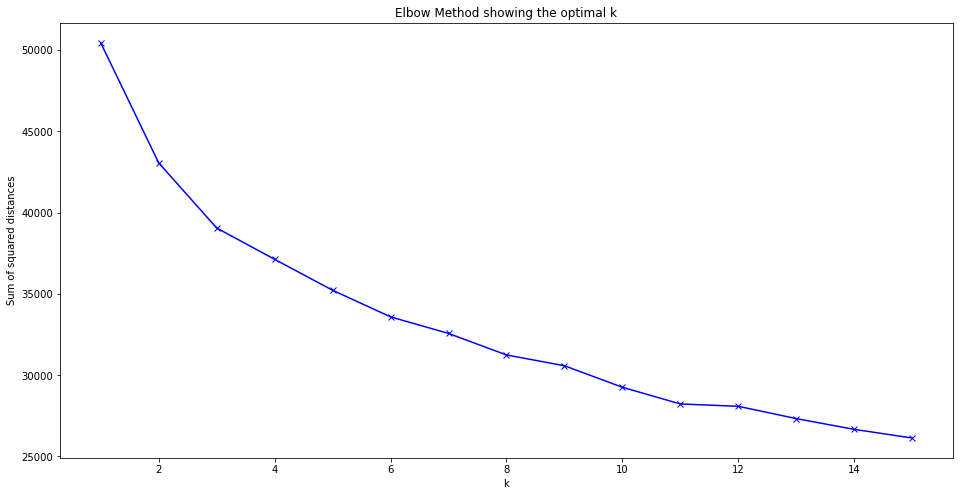

In [8]:
# Clusters size. From 1 to 20
k_clusters = [i for i in range(1,16)]
results = []
labels = []

for k in k_clusters:
    k_means = KMeans(n_clusters=k, random_state=0)
    k_means.fit(data)
    results.append(k_means.inertia_)

plt.figure(figsize=(16,8))
plt.plot(k_clusters, results, "bx-")
plt.xlabel("k")
plt.ylabel("Sum of squared distances")
plt.title("Elbow Method showing the optimal k")
plt.show()

#### As we can see in the graph above, it is hard to distinguish the "elbow" of the curve. 
#### Giving the behaviour of the curve, we could chose between 3, 4 and 5.
#### To help to decide what cluster is the best approach, we decided to create some visualizations, using PCA to reduce the dimensionality of the data.

In [9]:
k_means = KMeans(n_clusters=2, random_state=0)
k_means.fit(data)
labels = k_means.predict(data)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data)
principalDf = pd.DataFrame(data = principalComponents, columns = ["principal component 1", "principal component 2"])
finalDf = pd.concat([principalDf, pd.DataFrame(data=labels, columns=["target"])], axis = 1)

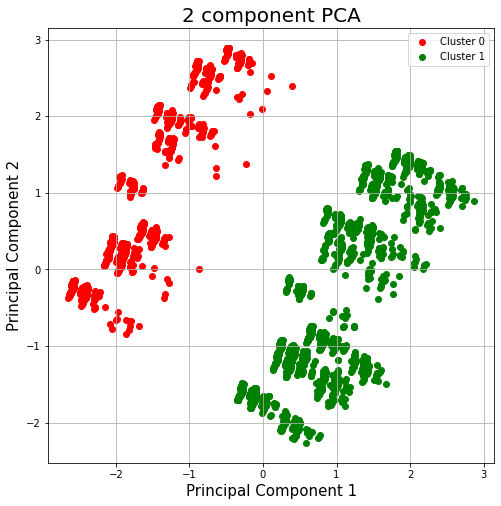

In [10]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel("Principal Component 1", fontsize = 15)
ax.set_ylabel("Principal Component 2", fontsize = 15)
ax.set_title("2 component PCA", fontsize = 20)
targets = [0, 1]
colors = ["r", "g"]
for target, color in zip(targets,colors):
    indicesToKeep = finalDf["target"] == target
    ax.scatter(finalDf.loc[indicesToKeep, "principal component 1"], 
               finalDf.loc[indicesToKeep, "principal component 2"], c = color)
ax.legend(["Cluster 0", "Cluster 1"])
ax.grid()
plt.show()

#### 3 clusters

In [11]:
k_means = KMeans(n_clusters=3, random_state=0)
k_means.fit(data)
labels = k_means.predict(data)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data)
principalDf = pd.DataFrame(data = principalComponents, columns = ["principal component 1", "principal component 2"])
finalDf = pd.concat([principalDf, pd.DataFrame(data=labels, columns=["target"])], axis = 1)

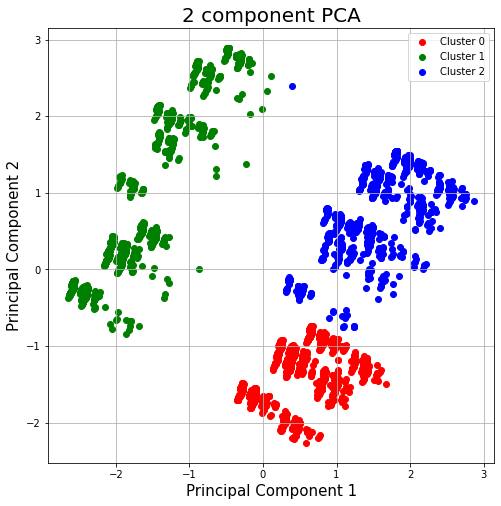

In [12]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel("Principal Component 1", fontsize = 15)
ax.set_ylabel("Principal Component 2", fontsize = 15)
ax.set_title("2 component PCA", fontsize = 20)
targets = [0, 1, 2]
colors = ["r", "g", "b"]
for target, color in zip(targets,colors):
    indicesToKeep = finalDf["target"] == target
    ax.scatter(finalDf.loc[indicesToKeep, "principal component 1"], 
               finalDf.loc[indicesToKeep, "principal component 2"], c = color)
ax.legend(["Cluster 0", "Cluster 1", "Cluster 2"])
ax.grid()
plt.show()

#### 4 clusters

In [13]:
k_means = KMeans(n_clusters=4, random_state=0)
k_means.fit(data)
labels = k_means.predict(data)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data)
principalDf = pd.DataFrame(data = principalComponents, columns = ["principal component 1", "principal component 2"])
finalDf = pd.concat([principalDf, pd.DataFrame(data=labels, columns=["target"])], axis = 1)

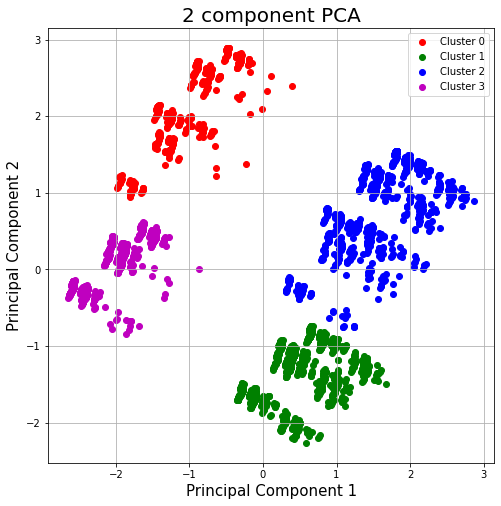

In [14]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel("Principal Component 1", fontsize = 15)
ax.set_ylabel("Principal Component 2", fontsize = 15)
ax.set_title("2 component PCA", fontsize = 20)
targets = [0, 1, 2, 3]
colors = ["r", "g", "b", "m"]
for target, color in zip(targets,colors):
    indicesToKeep = finalDf["target"] == target
    ax.scatter(finalDf.loc[indicesToKeep, "principal component 1"], 
               finalDf.loc[indicesToKeep, "principal component 2"], c = color)
ax.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"])
ax.grid()
plt.show()

#### 5 clusters

In [15]:
k_means = KMeans(n_clusters=5, random_state=0)
k_means.fit(data)
labels = k_means.predict(data)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data)
principalDf = pd.DataFrame(data = principalComponents, columns = ["principal component 1", "principal component 2"])
finalDf = pd.concat([principalDf, pd.DataFrame(data=labels, columns=["target"])], axis = 1)

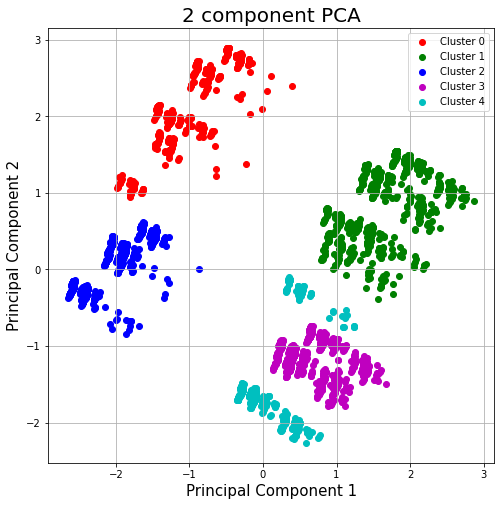

In [16]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel("Principal Component 1", fontsize = 15)
ax.set_ylabel("Principal Component 2", fontsize = 15)
ax.set_title("2 component PCA", fontsize = 20)
targets = [0, 1, 2, 3, 4]
colors = ["r", "g", "b", "m", "c"]
for target, color in zip(targets,colors):
    indicesToKeep = finalDf["target"] == target
    ax.scatter(finalDf.loc[indicesToKeep, "principal component 1"], 
               finalDf.loc[indicesToKeep, "principal component 2"], c = color)
ax.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"])
ax.grid()
plt.show()

#### Giving the visualizations above, we have decided that K=4 produces a good number of clusters

### **Extracting Insights**

In [17]:
k_means = KMeans(n_clusters=4, random_state=0)
k_means.fit(data)
labels = k_means.predict(data)

df_ = pd.concat([df, pd.DataFrame(data=labels, columns=["target"])], axis=1)

In [18]:
df_

,age,marital,education,housing.loan,personal.loan,contact,day.of.week,duration.contact,number.contatcs.campaign,poutcome,...,contact_telephone,day.of.week_fri,day.of.week_mon,day.of.week_thu,day.of.week_tue,day.of.week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,target
0,30,married,basic,1,0,cellular,fri,487,2,nonexistent,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
1,39,single,high.school,0,0,telephone,fri,346,4,nonexistent,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,25,married,high.school,1,0,telephone,wed,227,1,nonexistent,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3
3,47,married,university.degree,1,0,cellular,mon,58,1,nonexistent,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
4,32,single,university.degree,0,0,cellular,thu,128,3,failure,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3831,30,married,basic,1,1,cellular,thu,53,1,nonexistent,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1
3832,39,married,high.school,1,0,telephone,fri,219,1,nonexistent,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3
3833,27,single,high.school,0,0,cellular,mon,64,2,failure,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2
3834,58,married,high.school,0,0,cellular,fri,528,1,nonexistent,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


#### Term deposit population by cluster

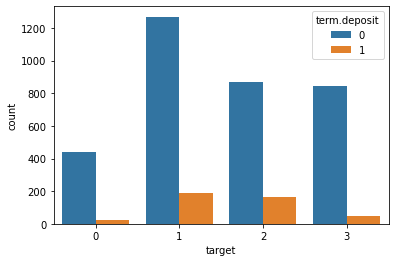

In [19]:
ax = sns.countplot(x="target", hue="term.deposit", data=df_)

#### Count of marital population by cluster

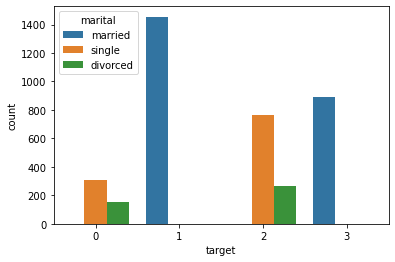

In [20]:
ax = sns.countplot(x="target", hue="marital", data=df_)

#### Age Boxplot

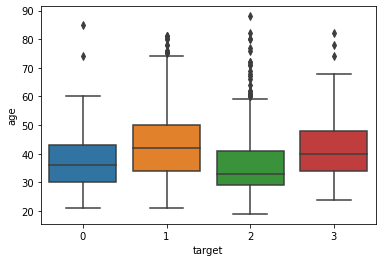

In [21]:
ax = sns.boxplot(x="target", y="age", data=df_)

#### Age Distribution

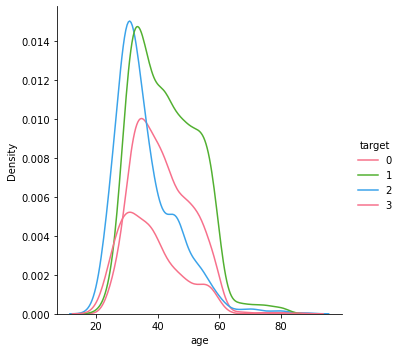

In [22]:
sns.displot(data=df_, x="age", hue="target", kind="kde", palette="husl")

#### Housing Loan Distribution

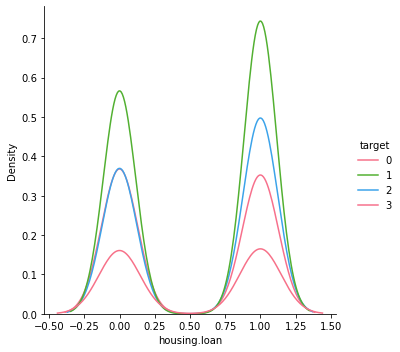

In [23]:
sns.displot(data=df_, x="housing.loan", hue="target", kind="kde", palette="husl")

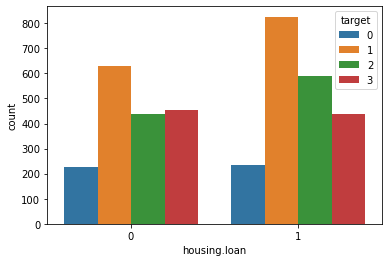

In [24]:
ax = sns.countplot(x="housing.loan", hue="target", data=df_)

#### Personal Loan

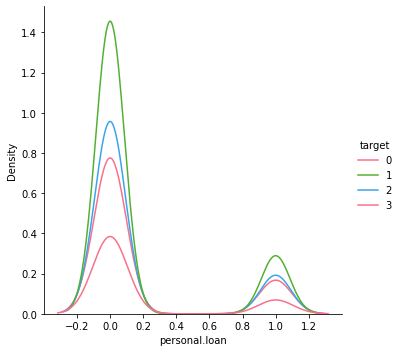

In [25]:
sns.displot(data=df_, x="personal.loan", hue="target", kind="kde", palette="husl")

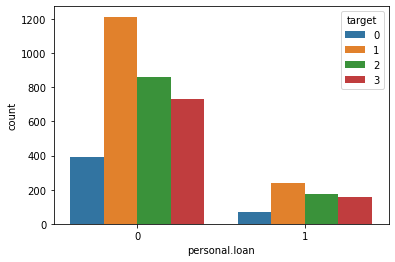

In [26]:
ax = sns.countplot(x="personal.loan", hue="target", data=df_)

#### Count of contact population by cluster

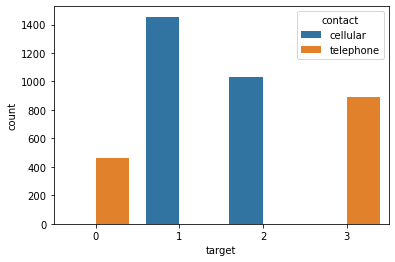

In [27]:
ax = sns.countplot(x="target", hue="contact", data=df_)

#### Count of days of the week by cluster

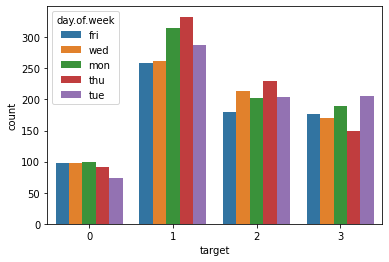

In [28]:
ax = sns.countplot(x="target", hue="day.of.week", data=df_)

#### Duration contact distribution

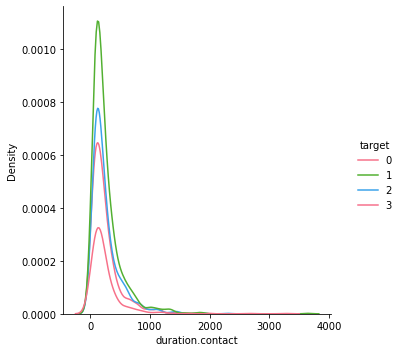

In [29]:
sns.displot(data=df_, x="duration.contact", hue="target", kind="kde", palette="husl")

#### Duration contact boxplot

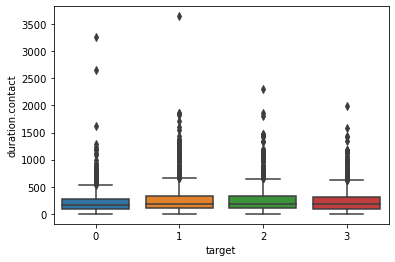

In [30]:
ax = sns.boxplot(x="target", y="duration.contact", data=df_)

#### Number of contacts distribution

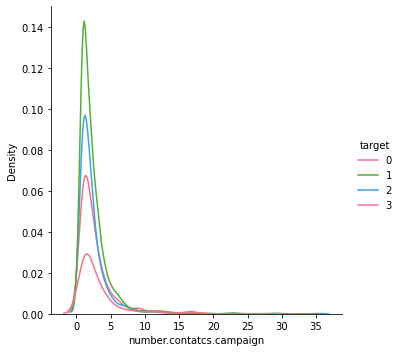

In [31]:
sns.displot(data=df_, x="number.contatcs.campaign", hue="target", kind="kde", palette="husl")

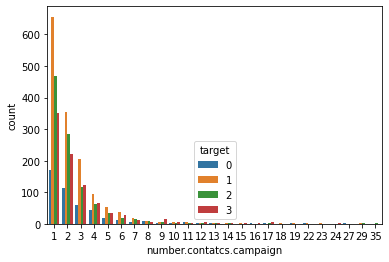

In [32]:
ax = sns.countplot(x="number.contatcs.campaign", hue="target", data=df_)

#### Number of contacts boxplot

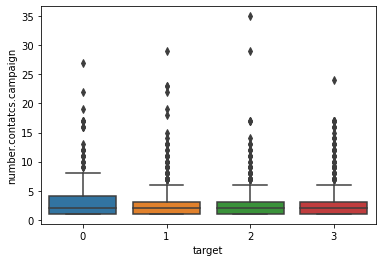

In [33]:
ax = sns.boxplot(x="target", y="number.contatcs.campaign", data=df_)

#### Count of Poutcome by cluster

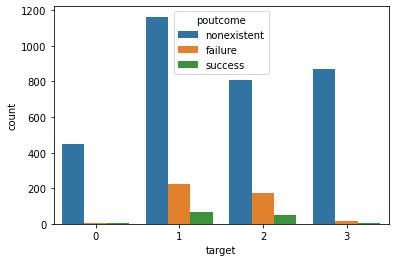

In [34]:
ax = sns.countplot(x="target", hue="poutcome", data=df_)

#### Pairs of features

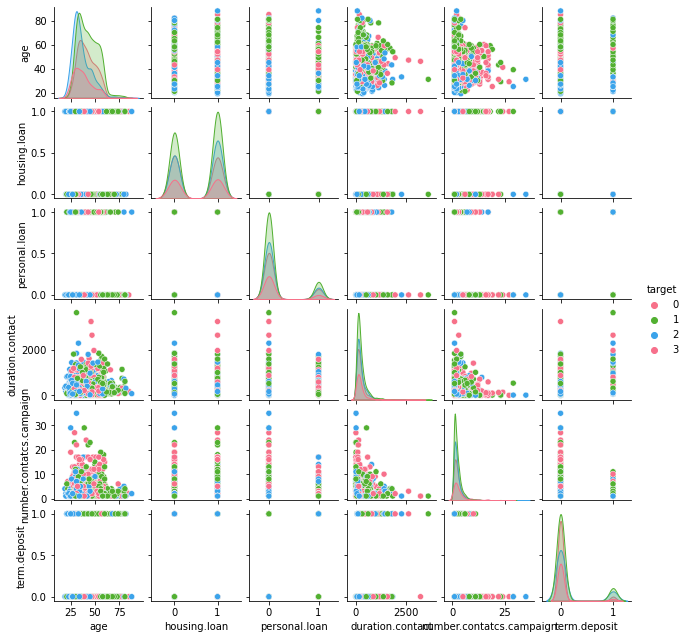

In [35]:
columns = ["age","marital","education","housing.loan",
           "personal.loan","contact","day.of.week",
           "duration.contact","number.contatcs.campaign",
           "poutcome","term.deposit","target"]

sns.pairplot(df_[columns], hue="target", height=1.5, palette="husl")